In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

import os
import matplotlib.pyplot as plt

In [ ]:
data_path = '/content/drive/MyDrive/HSE/DL/Project/data/features'

Предобработка данных

In [ ]:
def encode_labels(data):
    genres = np.unique(data.label)
    d_enc = dict([(x, i) for i, x in enumerate(genres)])
    return np.array([d_enc[x] for x in data.label]), genres

def preprocess(df: pd.Series):
    # Закодируем названия жанров в числа, сохраним словарик для декодирования
    # Так же сохраним названия файлов, чтобы потом суметь отыскать несоответствия
    y, genres = encode_labels(df)
    df = df.drop('label', axis=1)
    filenames = df.filename.to_numpy()
    df = df.drop('filename', axis=1)
    X = df.to_numpy()
    return X, y, genres, filenames

Кастомный split, который делит еще и имена файлов

In [ ]:
def my_train_test_split(X, y, filenames, test_size=0.2, seed=42):
    assert X.shape[0] == y.shape[0] == filenames.shape[0]
    np.random.seed = seed
    idx = np.random.permutation(X.shape[0])
    n = int(test_size * X.shape[0])

    X, y, filenames = X[idx], y[idx], filenames[idx]
    X_train, X_test = X[n:], X[:n]
    y_train, y_test = y[n:], y[:n]
    filenames_train, filenames_test = filenames[n:], filenames[:n]
    return X_train, X_test, y_train, y_test, filenames_train, filenames_test

Научимся считать метрики и строить графики
Сначала посчитаем accuracy и средние значения precision и recall. Интересно посмотреть, как выглядят метрики для разных классов. Это может дать информацию какие классы путает классификатор.

Так же учтем возможность простроения confusion matrix

In [ ]:
def count_metrics(y_true, y_pred, genres, average='macro', plot=True):
    # average metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average)
    rec = recall_score(y_true, y_pred,  average=average)
    print(f'Average: acc: {acc:.3f} prec: {prec:.3f} rec: {rec:.3f}')

    # mertics per class
    multi_recall = recall_score(y_true, y_pred, average=None)
    multi_precision = precision_score(y_true, y_pred, average=None)
    print('Per class precision, recall')
    for i, (pre, re) in enumerate(zip(multi_precision, multi_recall)):
        print(f'{genres[i]:>10}:  {pre:.3f}  {re:.3f}')
    
    return multi_precision, multi_recall, y_true, y_pred
    # make plots
    # if plot:
    #     _, ax1 = plt.subplots()
    #     plot_metric(ax1, multi_recall, genres, label='recall')
    #     _, ax2 = plt.subplots()
    #     plot_metric(ax2, multi_precision, genres, label='precision')
    #     cm = confusion_matrix(y_true, y_pred)
    #     disp = ConfusionMatrixDisplay(confusion_matrix=cm)    # display_labels=genres
    #     disp.plot()
    #     plt.show()


def plot_metric(ax, metric_array, genres, label):
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_stacked.html
    ax.bar(genres, metric_array, 0.35)
    plt.ylim(min(metric_array)-0.05)
    ax.set_ylabel(label)
    ax.set_title(f'multi {label}')
    # ax.legend()


Наши датасеты - csv файлы со статистическими данными для музыкальных композиций

In [ ]:
df_30 = pd.read_csv(os.path.join(data_path, 'features_30_sec.csv'))
df_3 = pd.read_csv(os.path.join(data_path, 'features_3_sec.csv'))

# Классификация 3 секундных файлов

In [ ]:
X, y, genres, filenames = preprocess(df_3)
seed=42

Жанры:

In [ ]:
list(genres)

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

## SVM

In [ ]:
model = SVC(C=15, random_state=seed, kernel='rbf', degree=5)

Обучим модель и посмотрим на метрики и confusion matrix

In [ ]:
X_train, X_test, y_train, y_test, filenames_train, filenames_test\
        = my_train_test_split(X, y, filenames, test_size=0.2, seed=seed)
scaler1 = StandardScaler()
scaler2 = StandardScaler()
X_train_norm = scaler1.fit_transform(X_train)
model.fit(X_train_norm, y_train)
y_test_pred = model.predict(scaler2.fit_transform(X_test))
multi_precision, multi_recall, y_true, y_pred = count_metrics(y_test, y_test_pred, genres)

Average: acc: 0.916 prec: 0.916 rec: 0.916
Per class precision, recall
     blues:  0.908  0.947
 classical:  0.927  0.976
   country:  0.908  0.872
     disco:  0.842  0.916
    hiphop:  0.941  0.928
      jazz:  0.885  0.934
     metal:  0.981  0.954
       pop:  0.931  0.903
    reggae:  0.946  0.918
      rock:  0.895  0.810


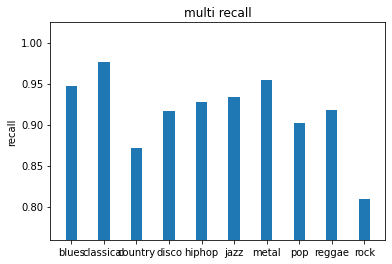

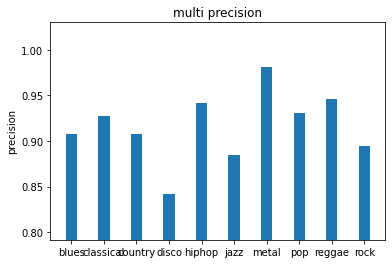

In [ ]:
_, ax1 = plt.subplots()
plot_metric(ax1, multi_recall, genres, label='recall')
_, ax2 = plt.subplots()
plot_metric(ax2, multi_precision, genres, label='precision')
plt.show()

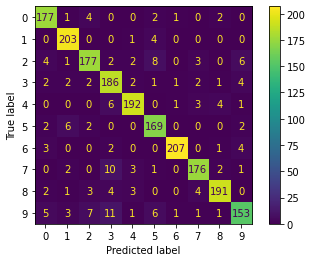

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)    # display_labels=genres
disp.plot()
None

Видно, что несколько композиций в стиле Рок (9 лейбл) классификатор отнес к классу Диско (3 лейбл). Можно найти эти файлы (и в дальнейшем послушать)

In [ ]:
idx_9_3 = (y_test == 9) & (y_test_pred == 3)
print(filenames_test[idx_9_3])
print(model.predict(scaler2.transform(X_test[idx_9_3])))

['rock.00050.7.wav' 'rock.00047.1.wav' 'rock.00081.0.wav'
 'rock.00081.4.wav' 'rock.00043.9.wav' 'rock.00000.4.wav'
 'rock.00031.7.wav' 'rock.00053.0.wav' 'rock.00084.0.wav'
 'rock.00038.8.wav' 'rock.00038.7.wav']
[3 3 3 3 3 3 3 3 3 3 3]


ИЛи же несколько композиций в стиле Регги (8 лейбл) были отнесены к классу Хип-хоп (4 лебл). Тоже с легкостью найдем их 

In [ ]:
idx_8_4 = (y_test == 8) & (y_test_pred == 4)
print(filenames_test[idx_8_4])
print(model.predict(scaler2.transform(X_test[idx_8_4])))

['reggae.00086.0.wav' 'reggae.00036.7.wav' 'reggae.00080.1.wav']
[4 4 4]


## kNN

In [ ]:
model = KNeighborsClassifier(n_neighbors=2, weights="distance")

In [ ]:
X_train, X_test, y_train, y_test, filenames_train, filenames_test\
        = my_train_test_split(X, y, filenames, test_size=0.2, seed=seed)
scaler1 = StandardScaler()
scaler2 = StandardScaler()
X_train_norm = scaler1.fit_transform(X_train)
model.fit(X_train_norm, y_train)
y_test_pred = model.predict(scaler2.fit_transform(X_test))
multi_precision, multi_recall, y_true, y_pred = count_metrics(y_test, y_test_pred, genres)

Average: acc: 0.894 prec: 0.895 rec: 0.894
Per class precision, recall
     blues:  0.918  0.914
 classical:  0.926  0.893
   country:  0.870  0.819
     disco:  0.828  0.910
    hiphop:  0.926  0.912
      jazz:  0.853  0.886
     metal:  0.970  0.941
       pop:  0.915  0.888
    reggae:  0.881  0.932
      rock:  0.861  0.845


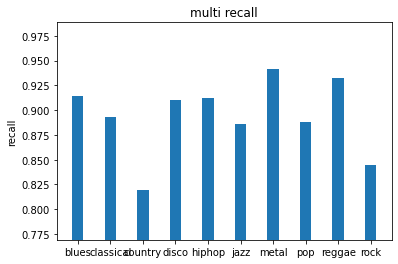

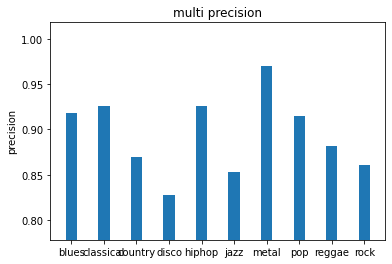

In [ ]:
_, ax1 = plt.subplots()
plot_metric(ax1, multi_recall, genres, label='recall')
_, ax2 = plt.subplots()
plot_metric(ax2, multi_precision, genres, label='precision')
plt.show()

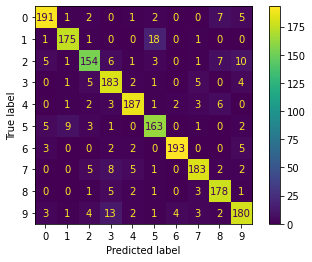

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)    # display_labels=genres
disp.plot()
None

## CatBoost

In [ ]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent',
    loss_function='MultiClass',
    l2_leaf_reg=0.01
)

In [ ]:
X_train, X_test, y_train, y_test, filenames_train, filenames_test\
        = my_train_test_split(X, y, filenames, test_size=0.2, seed=seed)
scaler1 = StandardScaler()
scaler2 = StandardScaler()
X_train_norm = scaler1.fit_transform(X_train)
model.fit(X_train_norm, y_train)
y_test_pred = model.predict(scaler2.fit_transform(X_test))
multi_precision, multi_recall, y_true, y_pred = count_metrics(y_test, y_test_pred, genres)

Average: acc: 0.903 prec: 0.902 rec: 0.903
Per class precision, recall
     blues:  0.930  0.915
 classical:  0.948  0.944
   country:  0.821  0.922
     disco:  0.860  0.856
    hiphop:  0.912  0.921
      jazz:  0.876  0.894
     metal:  0.947  0.943
       pop:  0.933  0.886
    reggae:  0.907  0.869
      rock:  0.889  0.880


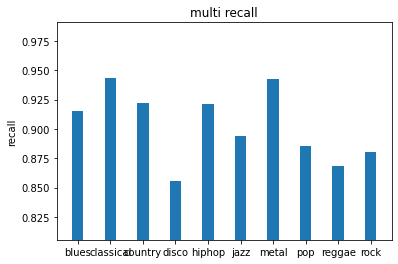

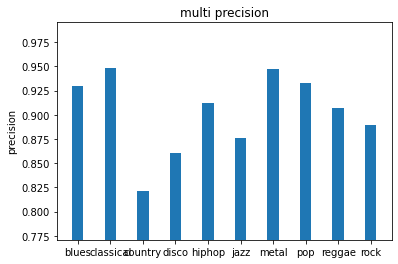

In [ ]:
_, ax1 = plt.subplots()
plot_metric(ax1, multi_recall, genres, label='recall')
_, ax2 = plt.subplots()
plot_metric(ax2, multi_precision, genres, label='precision')
plt.show()

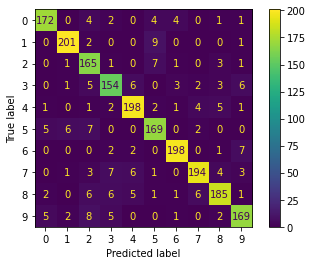

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)    # display_labels=genres
disp.plot()
None